In [104]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text

In [105]:
prot_ana = pd.read_csv('SourceData/prot_exp_data.csv').set_index('RID')
prot_info = pd.read_csv('SourceData/ADNI_Analyte_protein_info.csv')[['Analytes','EntrezGeneSymbol']].rename(columns={'Analytes': 'Compound'})

### Define functions

In [106]:
# Apply log reg and return the model
def log_reg(compound, data):
    # Define data
    X = data[[compound, 'AGE', 'PTGENDER', 'APOE4', 'PTEDUCAT']].copy()
    X = sm.add_constant(X)
    y = data['DX.bl']

    try:
        model = sm.Logit(y, X).fit(disp=0)
        return(model)

    except Exception as e:
        print(f"Model fitting failed for {compound}: {e}")
        return(None)

In [107]:
# Return parameters for the model
def extract_protein_stats(compound, model):

    coef = model.params[compound]
    pval = model.pvalues[compound]
    stderr = model.bse[compound]
    tvalue = model.tvalues[compound]

    return({'Compound': compound,
            'Estimate': coef,
            'StdErr': stderr,
            'z_score': tvalue,      # zscore and t-value are same in results
            'p_value': pval
            })


In [108]:
# Compute AUC for the model
def compute_protein_auc(compound, data):
    # Define data
    X = data[[compound, 'AGE', 'PTGENDER', 'APOE4', 'PTEDUCAT']]
    X = sm.add_constant(X)
    y = data['DX.bl']

    model = sm.Logit(y, X).fit(disp=0)

    try:
        y_pred_prob = model.predict(X)
        return(roc_auc_score(y, y_pred_prob))

    except Exception as e:
        print(f"AUC calculation failed for {compound}: {e}")
        return(None)

In [152]:
def assign_color(row):
    abs_est = abs(row['Estimate'])
    padj = row['padj_fdr']
    if abs_est > 0.5 and padj < 0.01:
        return 'red'  # significant + strong effect
    elif abs_est > 0.5 or padj < 0.01:
        return 'blue'  # either effect or significance
    else:
        return 'grey'


### Proteins CN vs AD

In [109]:
# Filter to CN and AD
prot_ana_cn_ad = prot_ana[prot_ana['DX.bl'].str.contains('CN|AD', case=False, na=False)].copy()  # <-- important!

# Binarization
prot_ana_cn_ad['PTGENDER'] = prot_ana_cn_ad['PTGENDER'].map({'Male': 1, 'Female': 0})
prot_ana_cn_ad['DX.bl'] = prot_ana_cn_ad['DX.bl'].map({'AD': 1, 'CN': 0})

# Define protein columns
prot_cols = [col for col in prot_ana_cn_ad.columns if col.startswith('X')]

#### Sample

In [110]:
prot_ana_cn_ad[['AGE', 'PTGENDER','DX.bl', 'X4179.57', 'PTEDUCAT', 'APOE4']]

,AGE,PTGENDER,DX.bl,X4179.57,PTEDUCAT,APOE4
RID,,,,,,
4488,72.6,1,0,-1.119295,18.0,0.0
4516,71.4,1,0,-1.288589,20.0,0.0
4464,70.4,1,0,-0.266295,16.0,1.0
4376,76.5,0,0,-0.400652,16.0,0.0
4900,59.8,0,0,-1.584072,18.0,0.0
...,...,...,...,...,...,...
459,72.9,1,0,0.266462,16.0,0.0
321,68.3,1,1,1.099447,18.0,2.0
866,80.0,0,0,-1.210787,13.0,0.0


In [111]:
model = log_reg('X4179.57', prot_ana_cn_ad)

In [112]:
extract_protein_stats('X4179.57', model)

{'Compound': 'X4179.57',
 'Estimate': 1.6454865172866324,
 'StdErr': 0.22277197406474292,
 'z_score': 7.386416196179212,
 'p_value': 1.508391446261621e-13}

In [113]:
compute_protein_auc('X4179.57', prot_ana_cn_ad)

0.8884405102837803

#### Application

In [114]:
logreg_results = []

for comp in prot_cols:
    model = log_reg(comp, prot_ana_cn_ad)
    stats = extract_protein_stats(comp, model)
    logreg_results.append(stats)

logreg_results = pd.DataFrame(logreg_results)

In [115]:
# fdr
rejected, pvals_corrected, _, _ = multipletests(logreg_results['p_value'], method='fdr_bh')
logreg_results['padj_fdr'] = pvals_corrected

# -log10(pval_fdr)
logreg_results['-log10(fdr)'] = -np.log10(logreg_results['padj_fdr'])

In [116]:
logreg_results

,Compound,Estimate,StdErr,z_score,p_value,padj_fdr,-log10(fdr)
0,X10000.28,-0.018222,0.139720,-0.130415,0.896238,0.980897,0.008377
1,X10001.7,0.058485,0.141972,0.411951,0.680375,0.949739,0.022396
2,X10003.15,0.115247,0.135736,0.849057,0.395850,0.874903,0.058040
3,X10006.25,0.011494,0.135691,0.084711,0.932492,0.987813,0.005325
4,X10008.43,-0.052454,0.127475,-0.411488,0.680715,0.949739,0.022396
...,...,...,...,...,...,...,...
6893,X9993.11,0.062589,0.144930,0.431861,0.665843,0.943241,0.025377
6894,X9994.217,-0.208289,0.135441,-1.537857,0.124084,0.662997,0.178489
6895,X9995.6,0.206584,0.149033,1.386158,0.165699,0.716607,0.144719
6896,X9997.12,0.315647,0.151272,2.086620,0.036923,0.392437,0.406230


#### Volcano plot
Significance = abs(Estimate) > 0.5 and -log10(fdr) < 0.01

In [117]:
logreg_results = pd.merge(logreg_results, prot_info, how='left', on='Compound')

In [118]:
logreg_results['color'] = logreg_results.apply(assign_color, axis=1)

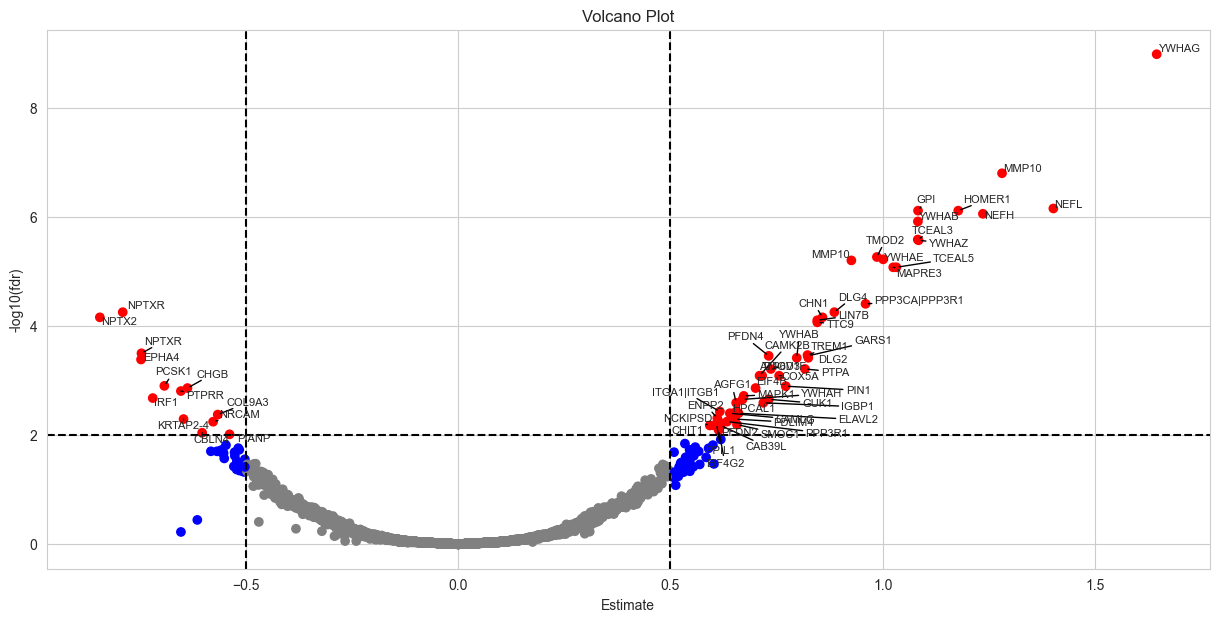

In [119]:
plt.figure(figsize=(15, 10))
# colours
plt.scatter(logreg_results['Estimate'], logreg_results['-log10(fdr)'],c=logreg_results['color'])
# text
texts = []
for _, row in logreg_results.iterrows():
    if row['color'] == 'red':
        texts.append(
            plt.text(
                row['Estimate'],
                row['-log10(fdr)'],
                row['EntrezGeneSymbol'],
                fontsize=8
            )
        )

# Repel labels to prevent overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

# other notations

plt.axhline(y=-np.log10(0.01), color='black', linestyle='--')
plt.axvline(x= 0.5, color='black', linestyle='--')
plt.axvline(x=-0.5, color='black', linestyle='--')
plt.xlabel('Estimate')
plt.ylabel('-log10(fdr)')
plt.title('Volcano Plot')
plt.show()

#### Differentially expressed proteins and AUC

In [120]:
# subset
de_cn_ad = logreg_results[logreg_results['color'] == 'red'].drop(columns='color')

auc_scores = []
# calculate AUC
for _, row in de_cn_ad.iterrows():
    auc_scores.append(compute_protein_auc(row['Compound'], prot_ana_cn_ad))

de_cn_ad['auc_score'] = auc_scores
de_cn_ad['Compare'] = 'CNvsAD'
de_cn_ad.to_csv('Results/multi/de_proteins_CNvsAD.csv', index=False)

### Proteins MCI vs AD

In [133]:
# Filter to MCI and AD
prot_ana_mci_ad = prot_ana[prot_ana['DX.bl'].str.contains('MCI|AD', case=False, na=False)].copy()  # <-- important!

# Binarization
prot_ana_mci_ad['PTGENDER'] = prot_ana_mci_ad['PTGENDER'].map({'Male': 1, 'Female': 0})
prot_ana_mci_ad['DX.bl'] = prot_ana_mci_ad['DX.bl'].map({'AD': 1, 'MCI': 0})

# Define protein columns
prot_cols = [col for col in prot_ana_mci_ad.columns if col.startswith('X')]

#### Application

In [134]:
logreg_results = []

for comp in prot_cols:
    model = log_reg(comp, prot_ana_mci_ad)
    stats = extract_protein_stats(comp, model)
    logreg_results.append(stats)

logreg_results = pd.DataFrame(logreg_results)

In [135]:
# fdr
rejected, pvals_corrected, _, _ = multipletests(logreg_results['p_value'], method='fdr_bh')
logreg_results['padj_fdr'] = pvals_corrected

# -log10(pval_fdr)
logreg_results['-log10(fdr)'] = -np.log10(logreg_results['padj_fdr'])

In [136]:
logreg_results

,Compound,Estimate,StdErr,z_score,p_value,padj_fdr,-log10(fdr)
0,X10000.28,-0.061140,0.106677,-0.573132,0.566555,0.881592,0.054732
1,X10001.7,-0.027863,0.104027,-0.267844,0.788819,0.955119,0.019942
2,X10003.15,0.196021,0.105459,1.858738,0.063064,0.457537,0.339574
3,X10006.25,-0.062243,0.101400,-0.613835,0.539324,0.870236,0.060363
4,X10008.43,-0.001099,0.103668,-0.010601,0.991542,0.997050,0.001283
...,...,...,...,...,...,...,...
6893,X9993.11,0.037688,0.103650,0.363612,0.716147,0.933461,0.029904
6894,X9994.217,-0.242167,0.105239,-2.301115,0.021385,0.309255,0.509683
6895,X9995.6,-0.067512,0.104158,-0.648174,0.516872,0.863732,0.063621
6896,X9997.12,0.082550,0.107898,0.765073,0.444228,0.838779,0.076353


#### Volcano plot
Significance = abs(Estimate) > 0.5 and -log10(fdr) < 0.01

In [137]:
logreg_results = pd.merge(logreg_results, prot_info, how='left', on='Compound')

In [138]:
logreg_results['color'] = logreg_results.apply(assign_color, axis=1)

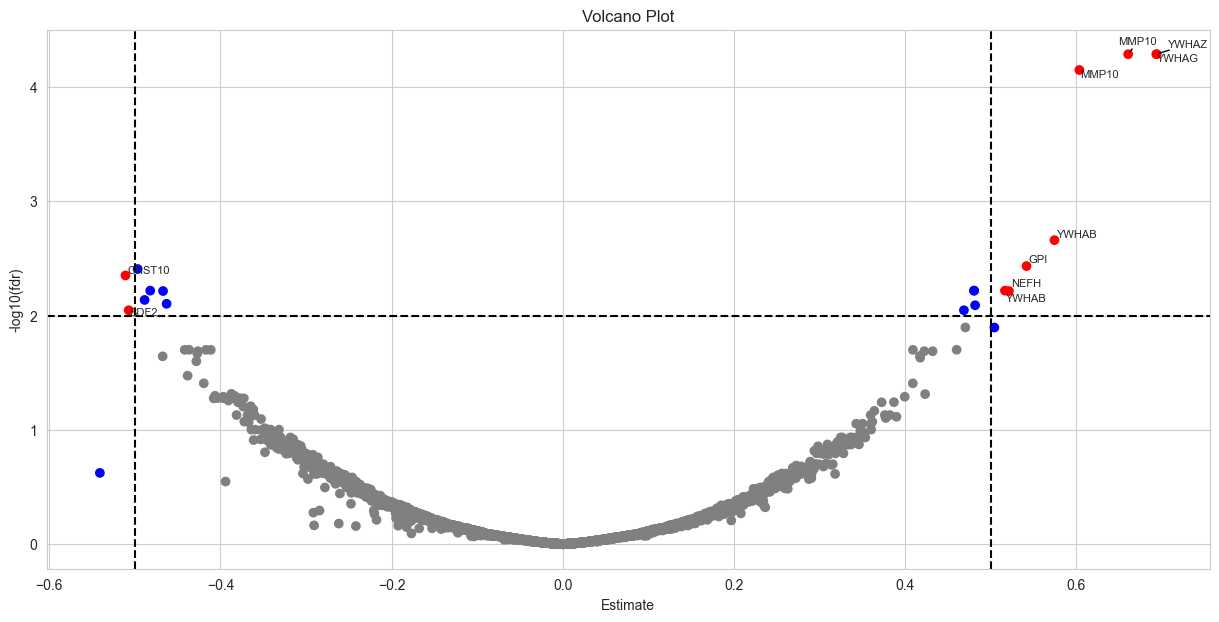

In [139]:
plt.figure(figsize=(15, 10))
# colours
plt.scatter(logreg_results['Estimate'], logreg_results['-log10(fdr)'],c=logreg_results['color'])
# text
texts = []
for _, row in logreg_results.iterrows():
    if row['color'] == 'red':
        texts.append(
            plt.text(
                row['Estimate'],
                row['-log10(fdr)'],
                row['EntrezGeneSymbol'],
                fontsize=8
            )
        )

# Repel labels to prevent overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

# other notations

plt.axhline(y=-np.log10(0.01), color='black', linestyle='--')
plt.axvline(x= 0.5, color='black', linestyle='--')
plt.axvline(x=-0.5, color='black', linestyle='--')
plt.xlabel('Estimate')
plt.ylabel('-log10(fdr)')
plt.title('Volcano Plot')
plt.show()

### Differentially expressed proteins and AUC

In [141]:
# subset
de_mci_ad = logreg_results[logreg_results['color'] == 'red'].drop(columns='color')

auc_scores = []
# calculate AUC
for _, row in de_mci_ad.iterrows():
    auc_scores.append(compute_protein_auc(row['Compound'], prot_ana_mci_ad))

de_mci_ad['auc_score'] = auc_scores
de_mci_ad['Compare'] = 'MCIvsAD'
de_mci_ad.to_csv('Results/multi/de_proteins_MCIvsAD.csv', index=False)

### Proteins CN vs MCI

In [142]:
# Filter to CN and MCI
prot_ana_cn_mci = prot_ana[prot_ana['DX.bl'].str.contains('CN|MCI', case=False, na=False)].copy()  # <-- important!

# Binarization
prot_ana_cn_mci['PTGENDER'] = prot_ana_cn_mci['PTGENDER'].map({'Male': 1, 'Female': 0})
prot_ana_cn_mci['DX.bl'] = prot_ana_cn_mci['DX.bl'].map({'MCI': 1, 'CN': 0})

# Define protein columns
prot_cols = [col for col in prot_ana_cn_mci.columns if col.startswith('X')]

#### Application

In [143]:
logreg_results = []

for comp in prot_cols:
    model = log_reg(comp, prot_ana_cn_mci)
    stats = extract_protein_stats(comp, model)
    logreg_results.append(stats)

logreg_results = pd.DataFrame(logreg_results)

In [144]:
# fdr
rejected, pvals_corrected, _, _ = multipletests(logreg_results['p_value'], method='fdr_bh')
logreg_results['padj_fdr'] = pvals_corrected

# -log10(pval_fdr)
logreg_results['-log10(fdr)'] = -np.log10(logreg_results['padj_fdr'])

In [145]:
logreg_results

,Compound,Estimate,StdErr,z_score,p_value,padj_fdr,-log10(fdr)
0,X10000.28,0.030256,0.100455,0.301187,0.763272,0.974435,0.011247
1,X10001.7,0.048270,0.100962,0.478100,0.632579,0.951613,0.021540
2,X10003.15,-0.080379,0.098099,-0.819361,0.412580,0.915624,0.038283
3,X10006.25,0.065545,0.099156,0.661025,0.508596,0.935976,0.028735
4,X10008.43,-0.054252,0.097863,-0.554366,0.579328,0.948584,0.022924
...,...,...,...,...,...,...,...
6893,X9993.11,0.030167,0.100619,0.299818,0.764316,0.974435,0.011247
6894,X9994.217,-0.009511,0.098952,-0.096113,0.923431,0.993450,0.002854
6895,X9995.6,0.180869,0.097913,1.847240,0.064712,0.729271,0.137111
6896,X9997.12,0.184911,0.099432,1.859665,0.062933,0.726542,0.138739


#### Volcano plot
Significance = abs(Estimate) > 0.5 and -log10(fdr) < 0.01

In [146]:
logreg_results = pd.merge(logreg_results, prot_info, how='left', on='Compound')

In [151]:
logreg_results['color'] = logreg_results.apply(assign_color, axis=1)

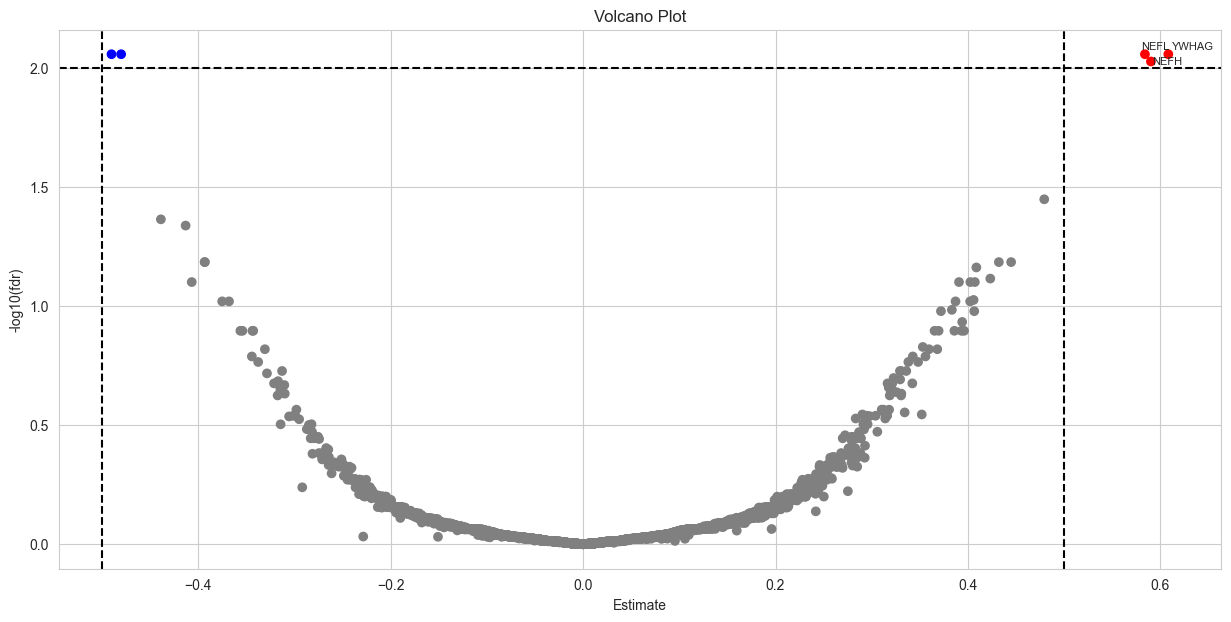

In [148]:
plt.figure(figsize=(15, 10))
# colours
plt.scatter(logreg_results['Estimate'], logreg_results['-log10(fdr)'],c=logreg_results['color'])
# text
texts = []
for _, row in logreg_results.iterrows():
    if row['color'] == 'red':
        texts.append(
            plt.text(
                row['Estimate'],
                row['-log10(fdr)'],
                row['EntrezGeneSymbol'],
                fontsize=8
            )
        )

# Repel labels to prevent overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))

# other notations

plt.axhline(y=-np.log10(0.01), color='black', linestyle='--')
plt.axvline(x= 0.5, color='black', linestyle='--')
plt.axvline(x=-0.5, color='black', linestyle='--')
plt.xlabel('Estimate')
plt.ylabel('-log10(fdr)')
plt.title('Volcano Plot')
plt.show()

### Differentially expressed proteins and AUC

In [149]:
# subset
de_cn_mci = logreg_results[logreg_results['color'] == 'red'].drop(columns='color')

auc_scores = []
# calculate AUC
for _, row in de_cn_mci.iterrows():
    auc_scores.append(compute_protein_auc(row['Compound'], prot_ana_cn_mci))

de_cn_mci['auc_score'] = auc_scores
de_cn_mci['Compare'] = 'CNvsMCI'
de_cn_mci.to_csv('Results/multi/de_proteins_CNvsMCI.csv', index=False)

### Combining DE proteins

In [ ]:
de_proteins =